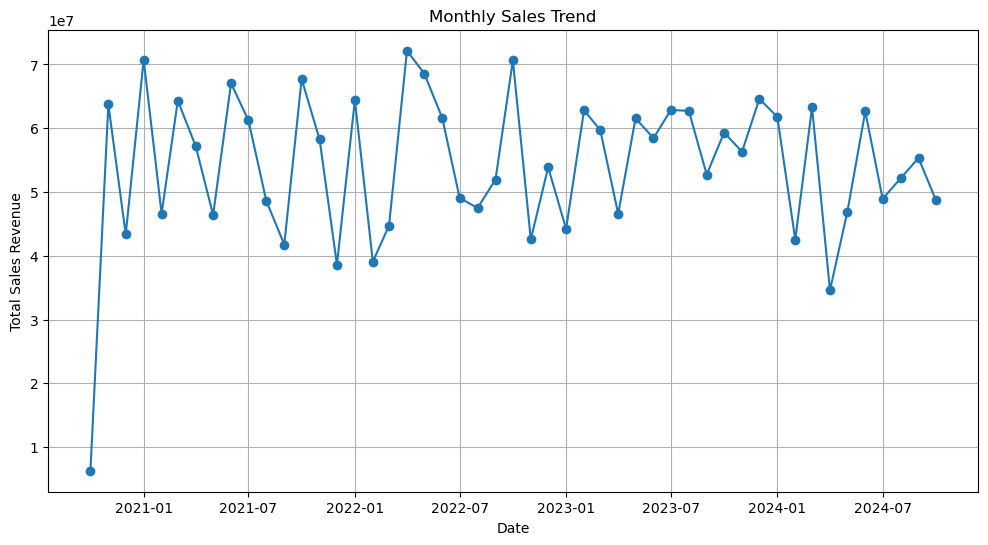

Forecasted Sales for Next Month: 2024-11-01    5.022894e+07
Freq: MS, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the datasets
prod_data = pd.read_csv("/Users/samleonor/Desktop/ITDA/DMP:MLPA/ProdData.csv")
trans_data = pd.read_csv("/Users/samleonor/Desktop/ITDA/DMP:MLPA/TransData.csv")

# Clean Product Data
prod_data.dropna(subset=['Product_ID'], inplace=True)
prod_data['Product_ID'] = prod_data['Product_ID'].astype(int)
prod_data['Product_Price'] = prod_data['Product_Price'].str.replace(r'[^\d.]', '', regex=True)
prod_data['Product_Price'] = pd.to_numeric(prod_data['Product_Price'], errors='coerce')

# Clean Transaction Data
trans_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
trans_data['Transaction_Date'] = pd.to_datetime(trans_data['Transaction_Date'], errors='coerce')
trans_data.dropna(subset=['Transaction_ID', 'Product_ID'], inplace=True)
trans_data['Transaction_ID'] = trans_data['Transaction_ID'].astype(int)
trans_data['Product_ID'] = trans_data['Product_ID'].astype(int)
trans_data.loc[:, 'Quantity'] = trans_data['Quantity'].fillna(trans_data['Quantity'].median())
trans_data.loc[:, 'Total_Cost'] = trans_data['Quantity'] * trans_data['Product_Price']

# Merge product and transaction data
merged_data = trans_data.merge(prod_data, on='Product_ID', how='left')

# Extract date-based features
merged_data['Year'] = merged_data['Transaction_Date'].dt.year
merged_data['Month'] = merged_data['Transaction_Date'].dt.month
merged_data['Day'] = merged_data['Transaction_Date'].dt.day
merged_data['DayOfWeek'] = merged_data['Transaction_Date'].dt.dayofweek

# Aggregate sales data per month
monthly_sales = merged_data.groupby(['Year', 'Month'])['Total_Cost'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))
monthly_sales.set_index('Date', inplace=True)
monthly_sales = monthly_sales[['Total_Cost']]

# Plot the historical sales trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Total_Cost'], marker='o', linestyle='-')
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales Revenue")
plt.grid(True)
plt.show()

# Train an Exponential Smoothing model
model = ExponentialSmoothing(monthly_sales, trend="add", seasonal="add", seasonal_periods=12)
fitted_model = model.fit(optimized=True, use_brute=True)

# Forecast for the next month
forecast_period = 1
forecast = fitted_model.forecast(steps=forecast_period)

# Display the forecasted sales
print("Forecasted Sales for Next Month:", forecast)